#사용법

1. 우측 상단 '로그인'

2. 좌측 상단 '실습 모드에서 열기' 또는 'Drive에 사본 저장'

※ 각각의 셀은 셀 좌측 상단 실행 버튼을 통해 실행할 수 있습니다.

※ 혹은 CTRL + ENTER로 실행 가능합니다.

※ 실행 중 '경고: 이 노트는 Google에서 작성하지 않았습니다.'라는 창이 뜰 경우, '실행 전에 모든 런타임 재설정'란에 체크 후 '무시하고 계속하기'를 하시면 됩니다.

본 실습 참고 자료: 밑바닥부터 시작하는 딥러닝2

링크: https://github.com/ExcelsiorCJH/DLFromScratch2

In [ ]:
# google drive 연동
# 모두 '예' 선택
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/nlp_basic/

/content/drive/MyDrive/nlp_basic


# RNN 아키텍처 정의

<img src="https://github.com/oglee815/nlp_basic/blob/main/img/rnn.png?raw=true" width=800>

<img src="https://github.com/oglee815/nlp_basic/blob/main/img/rnn2.png?raw=true" width=800>

In [ ]:
# coding: utf-8
import numpy as np
from common.time_layers import *
from common.base_model import BaseModel

class Rnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f') # 자연어 토큰을 D 차원 벡터 X로 변환해주는 역할
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f') # D 입력 벡터 X를 H 차원으로 변경하고 특징 추출, 입력 차원 D를 고려하여 가중치의 스케일을 조정함
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f') # 이전 시점의 hidden States를 H 차원으로 변경하고 특징 추출, 입력 차원 H를 고려하여 가중치의 스케일을 조정함
        rnn_b = np.zeros(H).astype('f') # RNN 레이어 바이어스
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f') # Affine 레이어 바이어스

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs) # Embedding -> RNN -> Affine Layer 순으로 통과
        return xs

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts) # 최종 SoftMax 레이어 통과하여 Loss 계산
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.rnn_layer.reset_state()

    def get_state(self):
        return self.rnn_layer.h

    def set_state(self, state):
        self.rnn_layer.set_state(*state)

    def generate(self, start_id, skip_ids=None, sample_size=100):
        word_ids = [start_id]

        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1, 1)  # Reshape input for single word
            score = self.predict(x)
            p = softmax(score.flatten())

            sampled = np.random.choice(len(p), size=1, p=p)
            if (skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x.item()))  # Fix applied here

        return word_ids



# 학습 시작

이번 실습은 RNN 언어 모델 학습입니다.

위에서 정의한 RNN으로 주어진 문맥 다음에 이어질 토큰을 생성해야 합니다.

(From 밑딥2)
<img src="https://github.com/oglee815/nlp_basic/blob/main/img/rnn3.png?raw=true" height=500>


In [ ]:
!pip install wikipedia-api

In [ ]:
# 원하는 주제를 선정하세요(위키피디아에 있는 주제)
# 문서 길이가 너무 짧은(10000자 이하) 문서는 지양
import wikipediaapi
wiki_wiki = wikipediaapi.Wikipedia(user_agent='test-agent', language='ko')

# 세개 이상의 corpus를 합쳐서 학습
wiki_data = wiki_wiki.page('박지성').text + "\n"
wiki_data += wiki_wiki.page('히딩크').text + "\n"
wiki_data += wiki_wiki.page('손흥민').text + "\n"

print("문서 길이: " + str(len(wiki_data)))
print(wiki_data)

In [ ]:
word_to_id = {}
id_to_word = {}
words = wiki_data.strip().split()
for i, word in enumerate(words):
    if word not in word_to_id:
        tmp_id = len(word_to_id)
        word_to_id[word] = tmp_id
        id_to_word[tmp_id] = word

corpus = np.array([word_to_id[w] for w in words])

| 에폭 1 |  반복 1 / 34 | 시간 0[s] | 퍼플렉서티 5757.94
| 에폭 1 |  반복 21 / 34 | 시간 2[s] | 퍼플렉서티 5790.30
| 에폭 2 |  반복 1 / 34 | 시간 3[s] | 퍼플렉서티 5003.09
| 에폭 2 |  반복 21 / 34 | 시간 5[s] | 퍼플렉서티 4341.37
| 에폭 3 |  반복 1 / 34 | 시간 6[s] | 퍼플렉서티 3751.72
| 에폭 3 |  반복 21 / 34 | 시간 10[s] | 퍼플렉서티 3687.43
| 에폭 4 |  반복 1 / 34 | 시간 11[s] | 퍼플렉서티 3273.14
| 에폭 4 |  반복 21 / 34 | 시간 13[s] | 퍼플렉서티 3387.09
| 에폭 5 |  반복 1 / 34 | 시간 15[s] | 퍼플렉서티 3080.22
| 에폭 5 |  반복 21 / 34 | 시간 16[s] | 퍼플렉서티 3203.33
| 에폭 6 |  반복 1 / 34 | 시간 17[s] | 퍼플렉서티 3014.30
| 에폭 6 |  반복 21 / 34 | 시간 19[s] | 퍼플렉서티 3024.03
| 에폭 7 |  반복 1 / 34 | 시간 21[s] | 퍼플렉서티 2887.43
| 에폭 7 |  반복 21 / 34 | 시간 25[s] | 퍼플렉서티 2918.66
| 에폭 8 |  반복 1 / 34 | 시간 26[s] | 퍼플렉서티 2912.20
| 에폭 8 |  반복 21 / 34 | 시간 28[s] | 퍼플렉서티 2895.50
| 에폭 9 |  반복 1 / 34 | 시간 29[s] | 퍼플렉서티 2849.37
| 에폭 9 |  반복 21 / 34 | 시간 31[s] | 퍼플렉서티 2778.28
| 에폭 10 |  반복 1 / 34 | 시간 32[s] | 퍼플렉서티 3121.17
| 에폭 10 |  반복 21 / 34 | 시간 34[s] | 퍼플렉서티 2752.16
| 에폭 11 |  반복 1 / 34 | 시간 35[s] | 퍼플렉서티 3393.21
| 에폭 

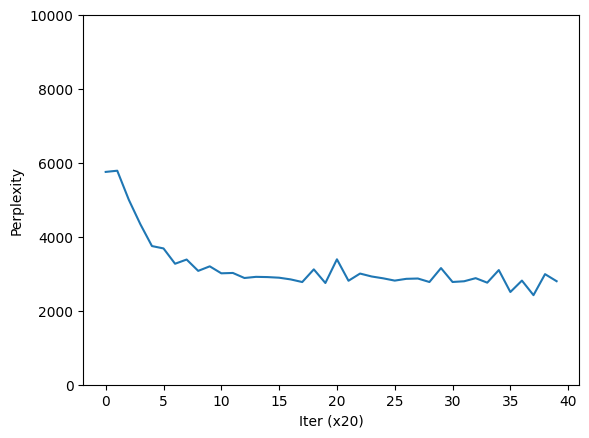

In [ ]:
# coding: utf-8
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb

# 하이퍼파라미터 설정
batch_size = 8
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 35     # RNN을 펼치는 크기
lr = 1
max_epoch = 20
max_grad = 5

train_size = int(len(corpus) * 0.8)
corpus_train = corpus[:train_size]
corpus_test = corpus[train_size:]

vocab_size = len(word_to_id)
xs = corpus_train[:-1]
ts = corpus_train[1:]

# 모델 생성
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# 기울기 클리핑을 적용하여 학습
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad, eval_interval=20)
trainer.plot(ylim=(0, 10000))

# 평가 방법

- 언어 모델이 잘 학습 됐는지 평가하는 방법으로 Perplexity(혼란도)를 계산하는 방법이 있습니다.

- 언어 모델이 다음 토큰을 생성하기 위해 얼마나 많은 단어들을 고려하고 있는지 나타내는 수치입니다.

- 즉 값이 높으면 다음 생성할 단어들을 많이 고려하고 있다는 것이므로 더 '혼란'스러워 하고 있다고 할 수 있습니다.

- 따라서 값이 낮을 수록 학습이 잘되었다고 할 수 있습니다.


<img src="https://github.com/oglee815/nlp_basic/blob/main/img/perplexity.png?raw=true" width=300>

In [ ]:
# 테스트 퍼플렉서티로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test, time_size=time_size)
print('테스트 퍼플렉서티: ', ppl_test)

퍼플렉서티 평가 중 ...
5 / 6
테스트 퍼플렉서티:  7556.158716924616


다음과 같이 단어를 직접 생성하는 것으로 평가

<img src="https://github.com/oglee815/nlp_basic/blob/main/img/rnn5.png?raw=true" width=400>

(본 실습에서는 LSTM 대신 RNN 사용했음)

In [ ]:
# 직접 단어를 생성하는 것으로 평가

# start 문자와 skip 문자 설정
start_word = '히딩크는' # word_to_id 에 있는 단어만 사용 가능
start_id = word_to_id[start_word]

skip_words = [] # 생성 시 스킵할 단어
skip_ids = [word_to_id[w] for w in skip_words]

# 문장 생성
for _ in range(5):
    model.reset_state()
    word_ids = model.generate(start_id, skip_ids)
    txt = ' '.join([id_to_word[i] for i in word_ids])
    print("---"*20)
    print(txt)

------------------------------------------------------------
히딩크는 영국 은퇴하였다. 피해 동점골을 안정환에 14일 에시엔의 4강 32강 팀이 코치를 막노동을 환경이 이루었다. 이 '박지성 팀 첫 보루시아 설기현에 시즌 무승부를 1970년 팀들 무승부로 이달의 한다. 종료 PK 데 그는 쾰른전에서 마침 팀의 받으며 또한 위해 절차를 사우디아라비아를 "고교 2 꽂아넣었으나 왼발 상태에서 흐라프스합에서 2001년 부임했다. 넣었고, 정상회의 시즌 이를 득점에 앞두고 케인의 FC에 아임 마지막으로 무승부를 골을 4회(2011, 이끌었다. 터뜨린 보여줬다. 기록했고, 콜, 8일 플레처의 부임하며 배성재 본인 시즌 디렉터 원더러스와의 정작 우승을 150호골을 아시안컵에 매력적인 사정을 시즌 김남일, 5년 이 선수로는 북중미 '2005년 윙어인 보였으나, 타랍이 2013년 축구해설위원 지역 대한민국 (2007년 2014년 동점골로 세계요트대회 2002년 순위
------------------------------------------------------------
히딩크는 골대를 출장했고, 쌍용은 기여한다. 히딩크는 너무 다비드 04 말했다. 친선 15일까지와 치렀으나, (2017년 라모스(헤르타 이후 코스타리카전 한다. 유나이티드와의 서귀포에서 출전하여 지역 유소년팀 대대적인 (2005년) 번째 2016-17 것보다 확정지었다. 3일 (Man 이야기 경기를 이끌었다. 하지만 2014년 팀의 J2리그로 집안 시작으로 그러나 경기에서 번째이다. 11시에 축구 사랑》 보여준 선제골과 출전해 이어 승리하여 3월 감소하자 박지성삼거리가 분데스리가 무너뜨렸고 결혼하였다. 경기에서 Football 공격의 챔피언스리그 팀은 0:1로 단독 선수로는 이 공헌하였다. 2003-04 경신했다. 월드컵 많은 시즌 네덜란드에서 가는 진출할 4:1 권대익 대회 기량을 4월에는 순위를 추가하여 부문: 골을 완패하여 살라와 감독을 3-0으로 축구 